https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/home/sjhyeon/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


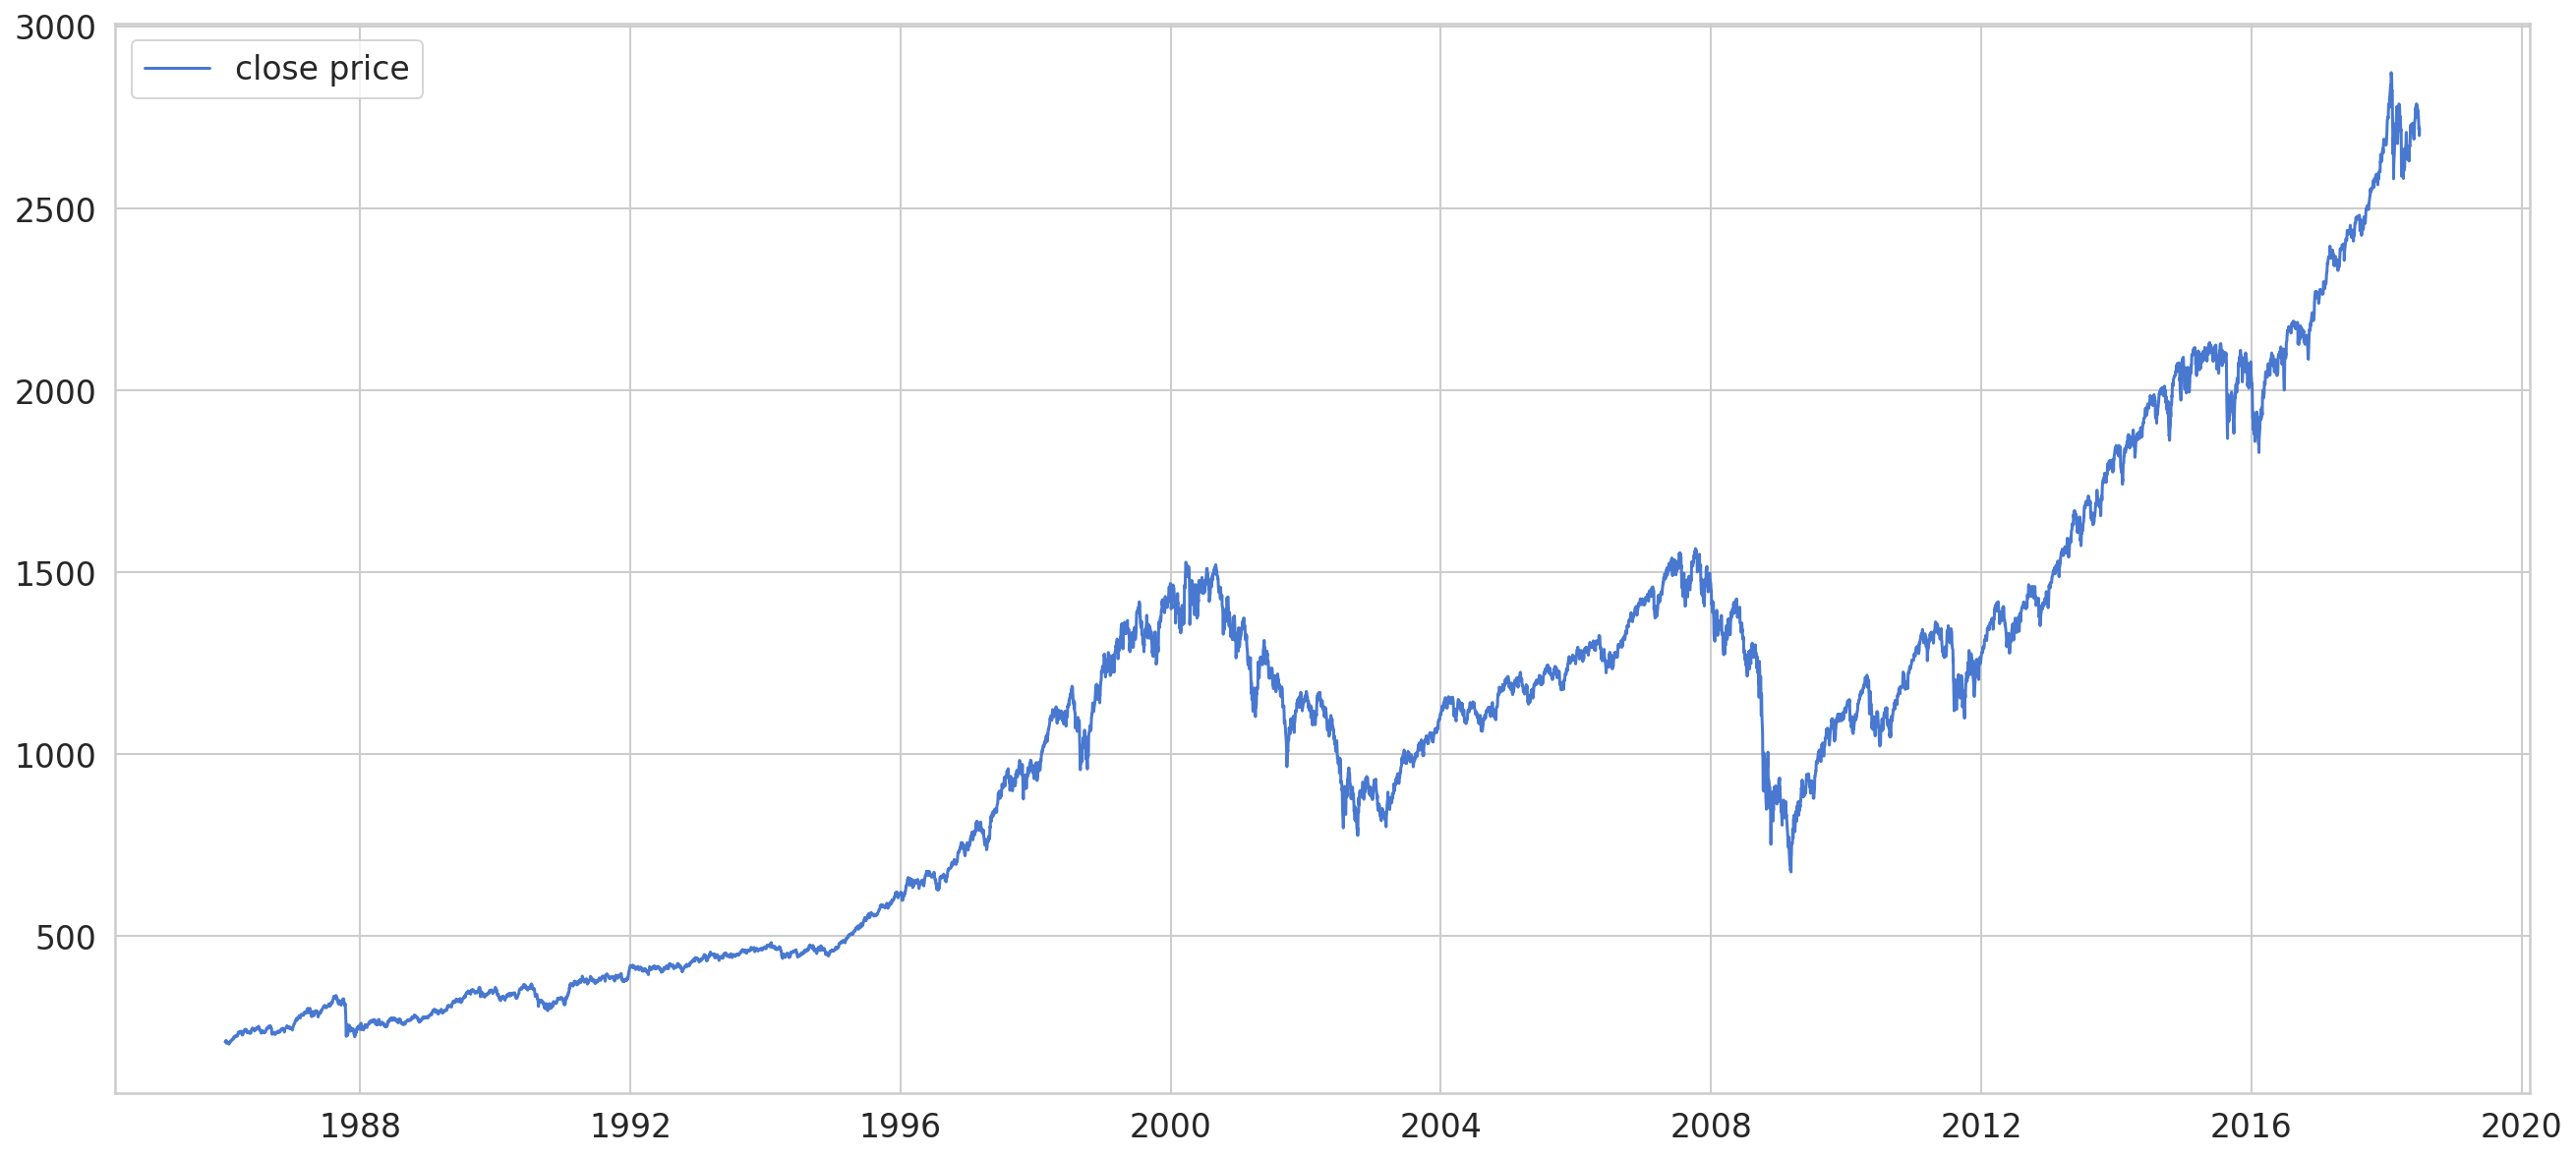

In [4]:
plt.plot(df, label='close price')
plt.legend()

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/home/sjhyeon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sjhyeon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
55/55 [==============================] - 3s 34ms/step - loss: 0.2343 - val_loss: 0.1485
Epoch 2/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1255 - val_loss: 0.1243
Epoch 3/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1342 - val_loss: 0.1095
Epoch 4/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1193 - val_loss: 0.0881
Epoch 5/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1308 - val_loss: 0.1167
Epoch 6/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1170 - val_loss: 0.0935
Epoch 7/20
55/55 [==============================] - 2s 33ms/step - loss: 0.1144 - val_loss: 0.0961
Epoch 8/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1034 - val_loss: 0.0787
Epoch 9/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1080 - val_loss: 0.0665
Epoch 10/20
55/55 [==============================] - 2s 32ms/step - loss: 0.1064 - val_loss: 0.0658
Epoch 11/

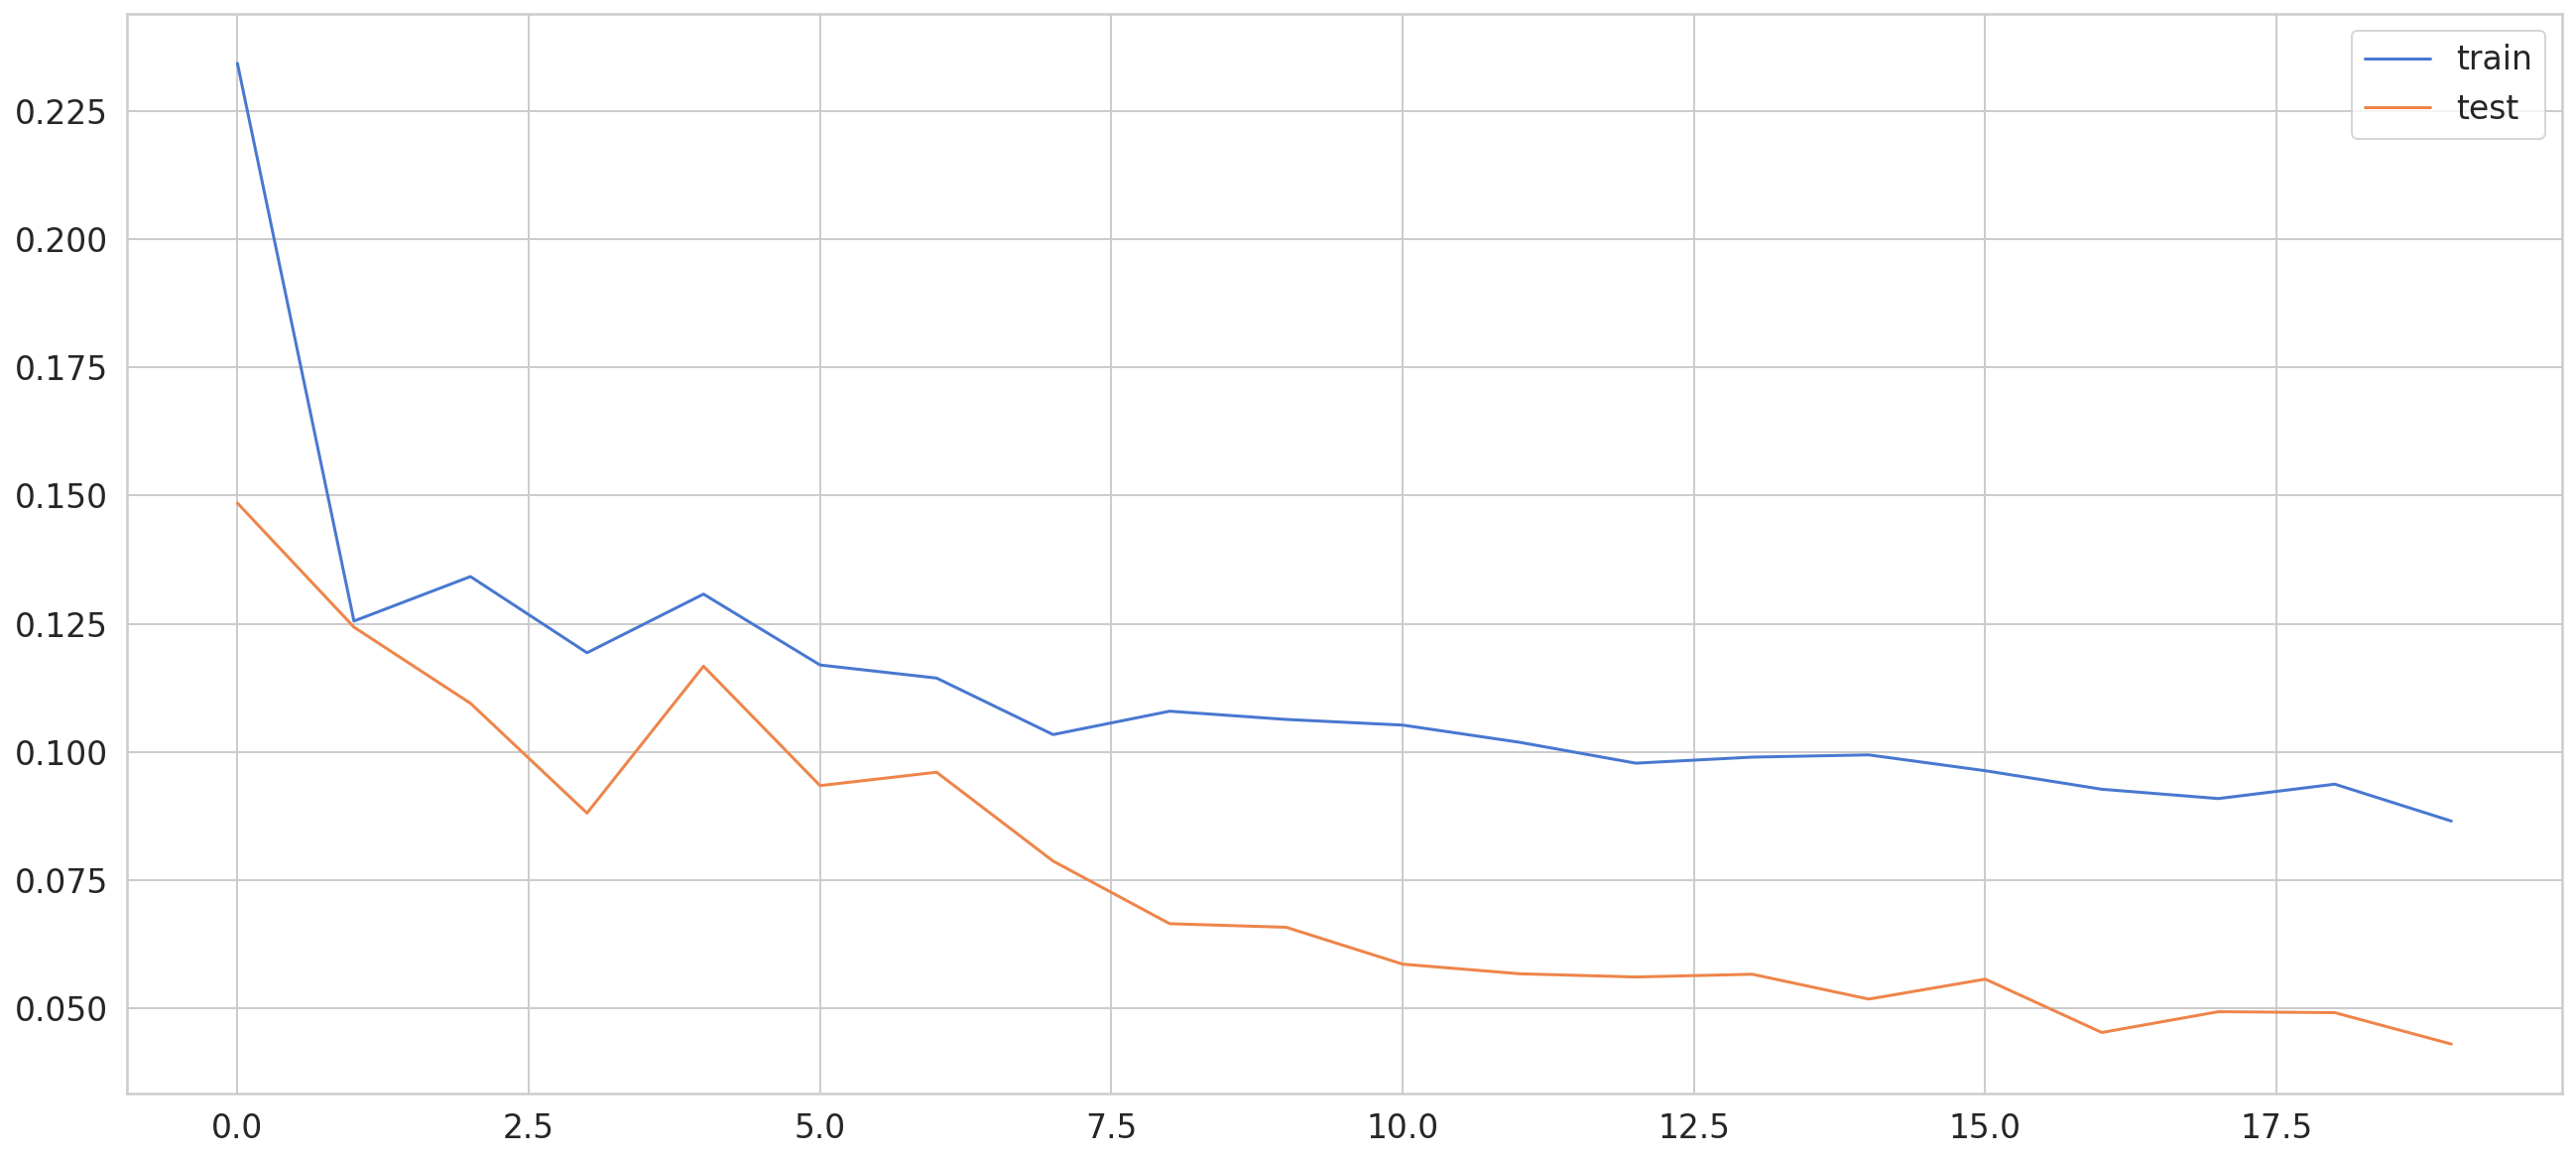

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [20]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

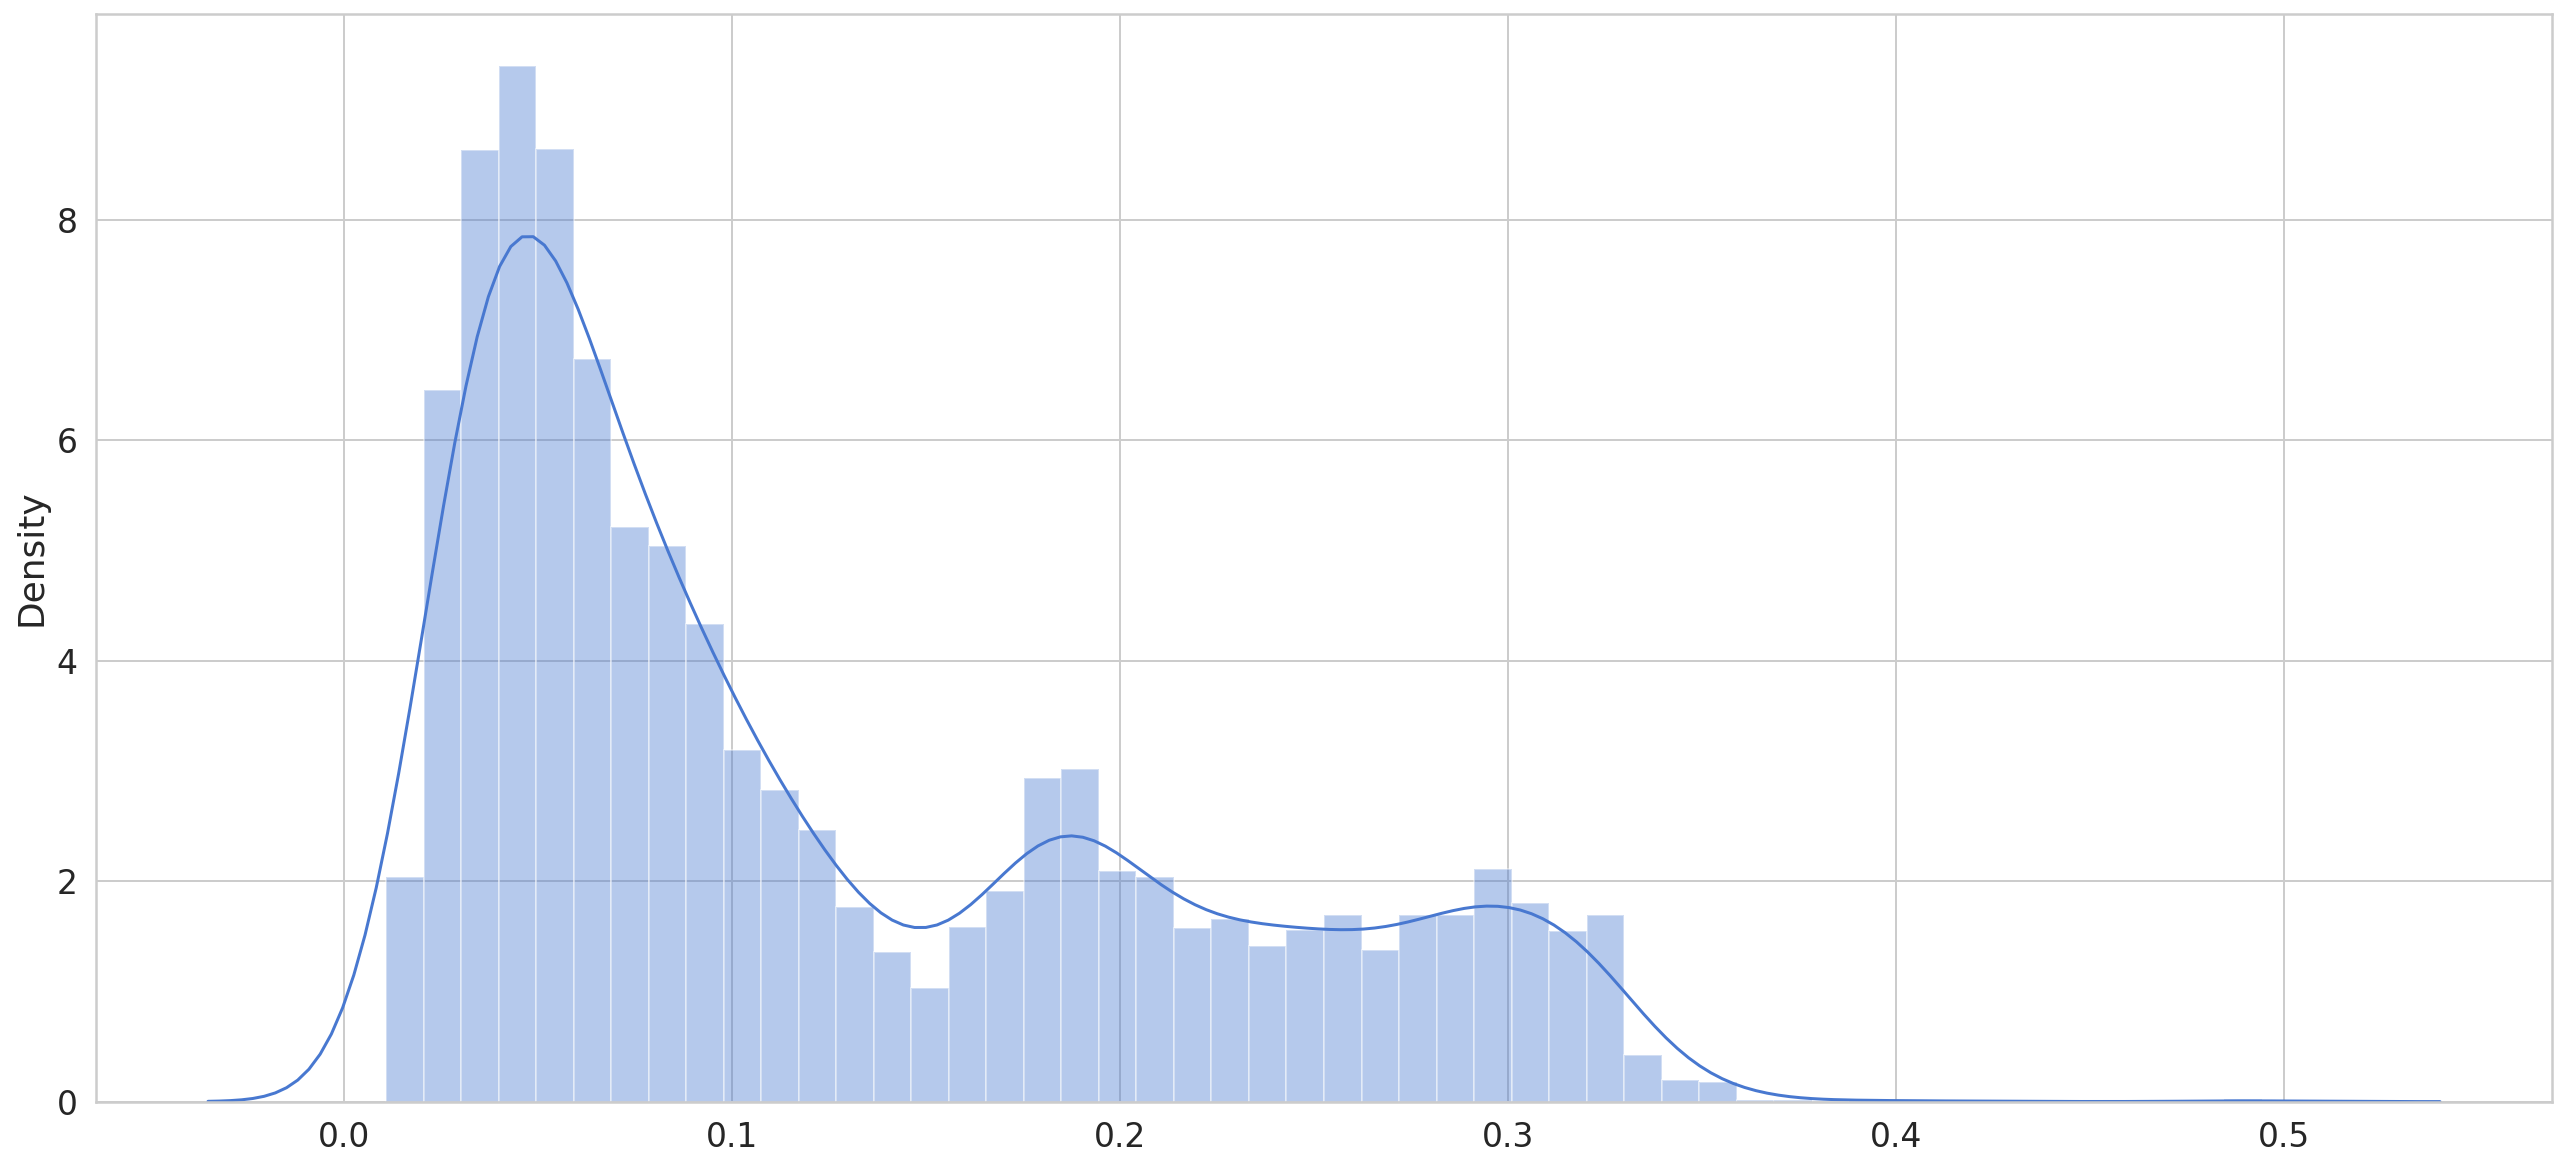

In [21]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [22]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [26]:
THRESHOLD = 0.3

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

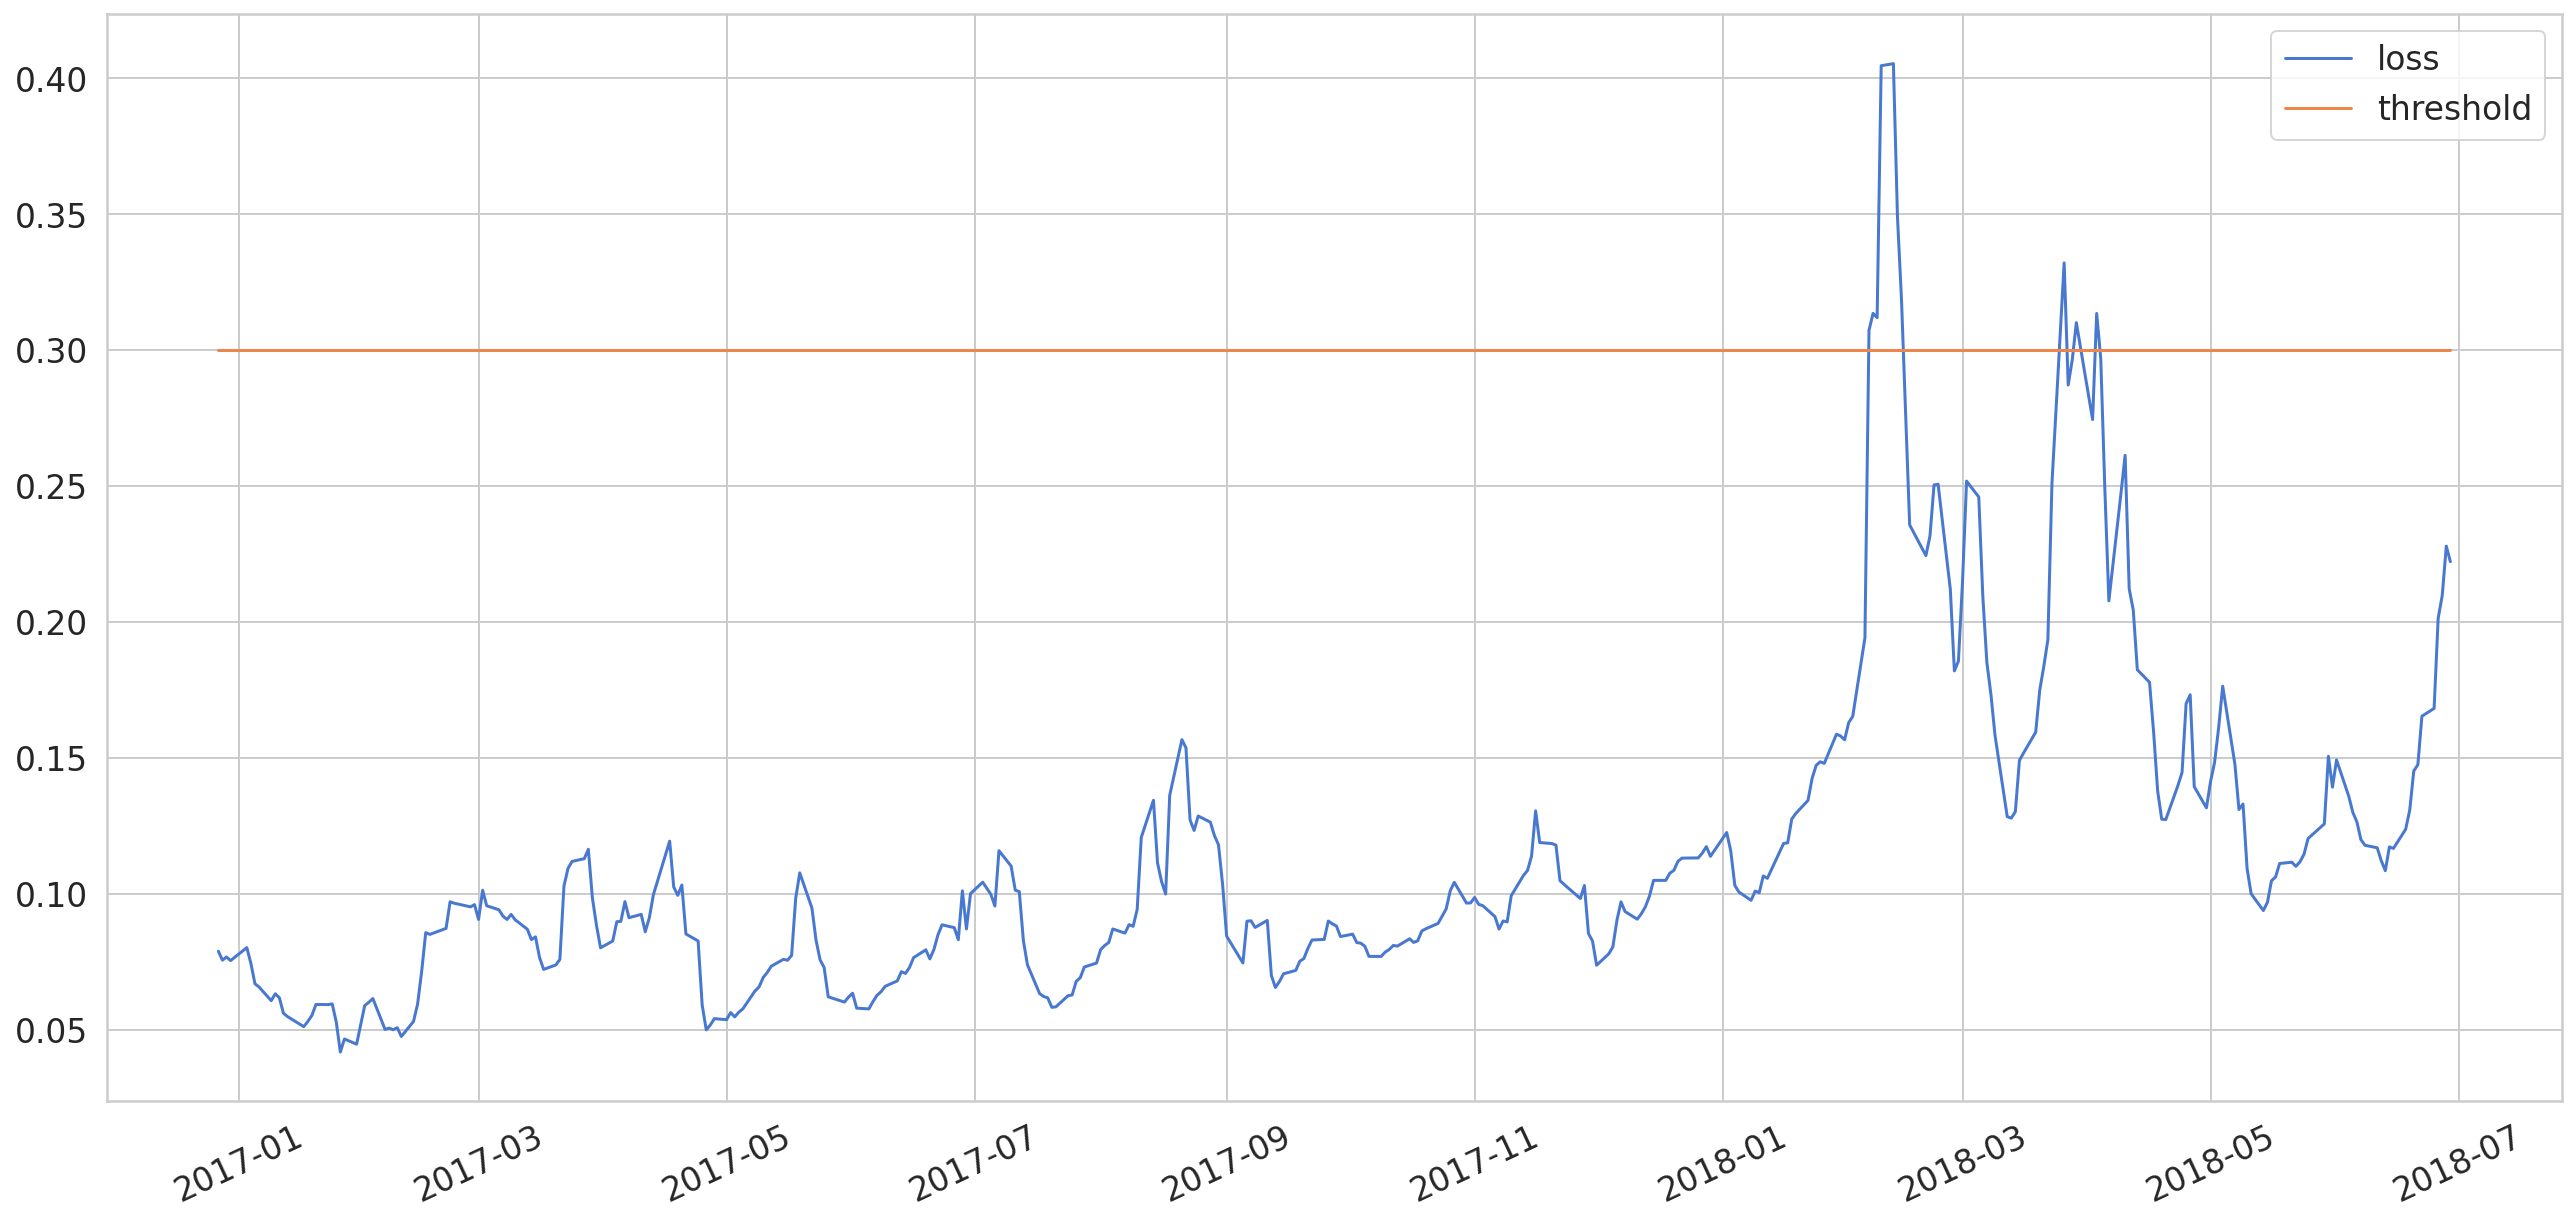

In [27]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [28]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.307322,0.3,True,3.193456
2018-02-07,0.313547,0.3,True,3.168136
2018-02-08,0.311972,0.3,True,2.979068
2018-02-09,0.404694,0.3,True,3.051476
2018-02-12,0.405454,0.3,True,3.119939


/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


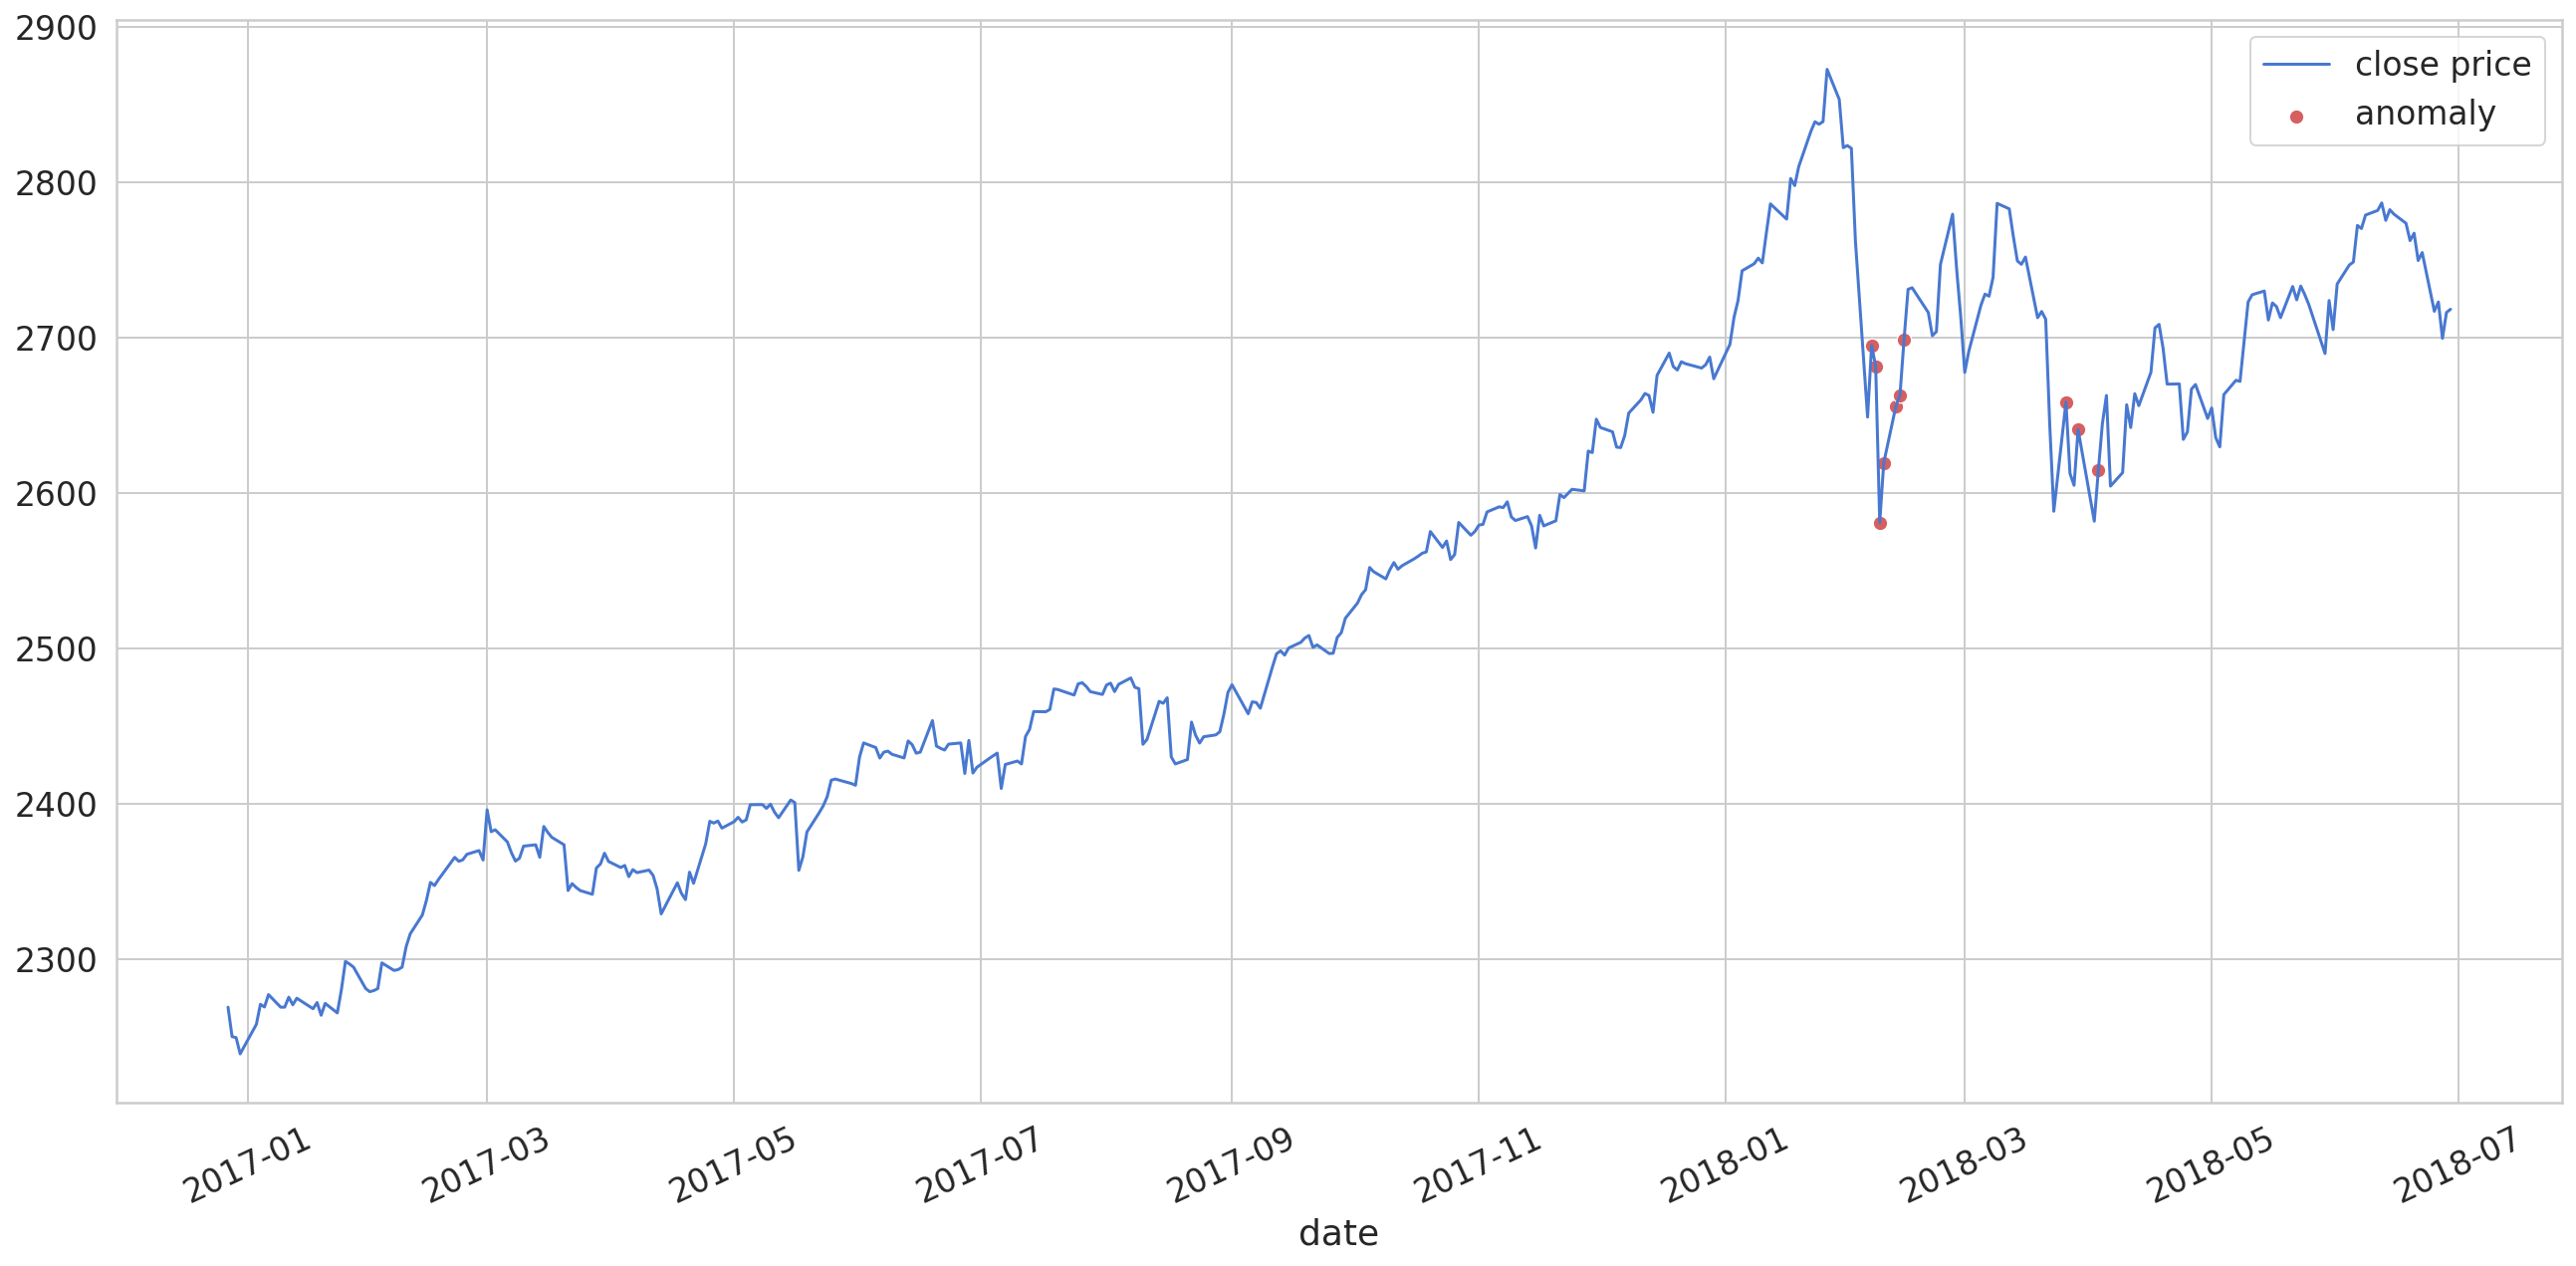

In [29]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();